# SLODR Without Imputation

**Goal:** Test Spearman's Law of Diminishing Returns using only observed data — no imputation.

## Why?
KNN imputation fills missing benchmark scores with smooth neighbour-averages. If less capable models
have more missing data, imputation artificially compresses their profiles, inflating the first PC's
explained variance for low-capability bins. This can create a spurious SLODR effect.

## Strategy
Instead of building a complete model×benchmark matrix, we work with **pairwise benchmark correlations**
computed only from models that were actually tested on both benchmarks in a pair.

1. **Capability proxy**: Mean observed benchmark score per model (no imputation needed)
2. **Tier split**: Divide models into capability tiers using this proxy
3. **Pairwise correlations per tier**: For each tier, compute benchmark-benchmark correlations
   using only the models in that tier with observed scores on both benchmarks
4. **SLODR test**: If average inter-benchmark correlation decreases with capability tier → SLODR
5. **Visual**: Scatter plots of benchmark pairs showing correlation tightness per tier
6. **Sliding window**: Continuous version of the tier analysis
7. **Permutation test**: Statistical significance without parametric assumptions


In [1]:
import pandas as pd

# --- knobs you can tweak ---
release_year_min = 2023        # keep benchmarks released in this year or later
min_scores_per_model = 4       # each model must have >= this many scores

allow_benchmarks_by_name = []
allow_benchmarks_by_id = []

sheet_id = '1v3Uvw6pAdj5jKNnLhhBfaGHzeBgZIRor6qF8SuUR7AM'
tab_gid = '1152942641'  # main: 282408316

google_sheet_url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={tab_gid}'

try:
    df_data = pd.read_csv(google_sheet_url)

    rows_before = len(df_data)
    models_before = df_data["model_id"].nunique() if "model_id" in df_data else None
    benches_before = df_data["benchmark_id"].nunique() if "benchmark_id" in df_data else None

    required_cols = ["model_id", "benchmark_id", "performance", "benchmark_release_date", "benchmark"]
    missing = [c for c in required_cols if c not in df_data.columns]
    if missing:
        raise KeyError(f"Missing required column(s): {missing}")

    df_data["performance"] = pd.to_numeric(df_data["performance"], errors="coerce")
    df_data["benchmark_release_date"] = pd.to_datetime(df_data["benchmark_release_date"], errors="coerce")
    df_data = df_data.dropna(subset=["model_id", "benchmark_id", "performance", "benchmark_release_date"])
    df_data = df_data[df_data["benchmark_release_date"].dt.year >= release_year_min]

    allowed_ids = set(str(x) for x in allow_benchmarks_by_id if str(x).strip())
    names_not_found = []
    if allow_benchmarks_by_name:
        tmp = df_data[["benchmark_id", "benchmark"]].dropna().drop_duplicates()
        name_to_ids = (
            tmp.assign(_name_norm=tmp["benchmark"].astype(str).str.strip().str.lower())
               .groupby("_name_norm")["benchmark_id"]
               .apply(lambda s: set(s.astype(str)))
               .to_dict()
        )
        for raw_name in allow_benchmarks_by_name:
            key = str(raw_name).strip().lower()
            if key in name_to_ids:
                allowed_ids |= name_to_ids[key]
            else:
                names_not_found.append(raw_name)
    if allowed_ids:
        df_data = df_data[df_data["benchmark_id"].astype(str).isin(allowed_ids)]

    counts = df_data.groupby("model_id")["performance"].count()
    keep_models = counts[counts >= min_scores_per_model].index
    df_data = df_data[df_data["model_id"].isin(keep_models)]

    rows_after = len(df_data)
    models_after = df_data["model_id"].nunique()
    benches_after = df_data["benchmark_id"].nunique()

    print("Successfully loaded and filtered Google Sheet tab as CSV.")
    print(f"Rows: {rows_before} -> {rows_after}")
    print(f"Models (unique): {models_before} -> {models_after}")
    print(f"Benchmarks (unique): {benches_before} -> {benches_after}")
    print(f"Kept benchmarks with release year >= {release_year_min} and models with >= {min_scores_per_model} scores.")
    display(df_data.head())

except Exception as e:
    print(f"Error loading data: {e}")


Successfully loaded and filtered Google Sheet tab as CSV.
Rows: 1097 -> 515
Models (unique): 139 -> 63
Benchmarks (unique): 39 -> 24
Kept benchmarks with release year >= 2023 and models with >= 4 scores.


,benchmark_id,model_id,benchmark_release_date,benchmark,model,performance
0,b1,m64,2023-11-20,GPQA diamond,gpt-5-nano-2025-08-07,0.5920
1,b2,m64,2025-02-28,FrontierMath-2025-02-28-Private,gpt-5-nano-2025-08-07,0.0830
2,b39,m64,2025-01-30,VPCT,gpt-5-nano-2025-08-07,0.3720
4,b1,m63,2023-11-20,GPQA diamond,gpt-5-mini-2025-08-07,0.6667
5,b19,m63,2025-02-21,Fiction.LiveBench,gpt-5-mini-2025-08-07,0.6940


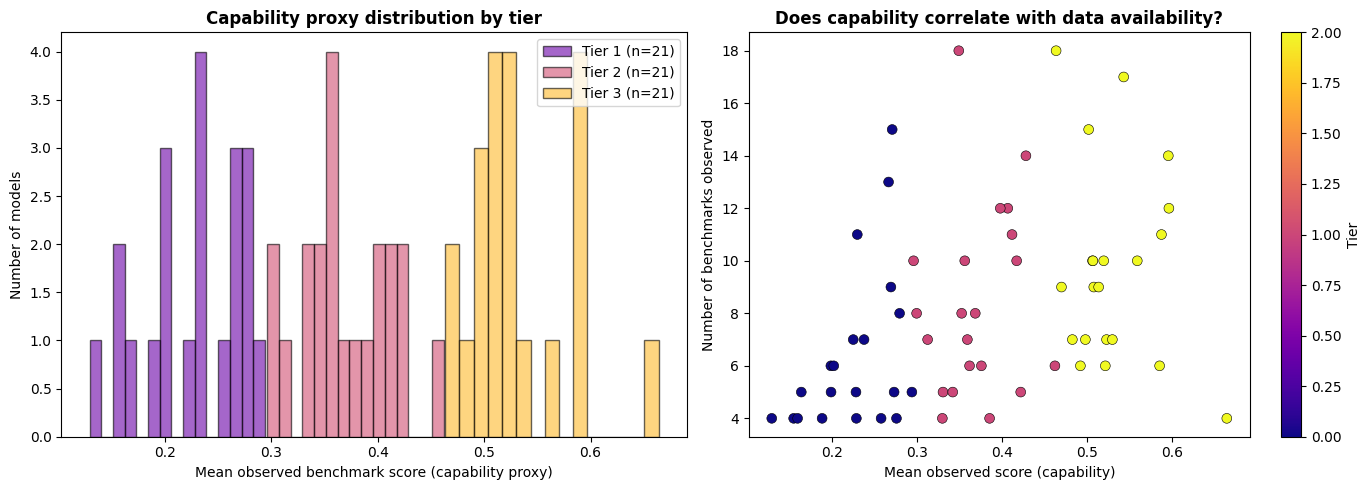

Correlation of capability with # observed benchmarks: r = +0.379, p = 0.0022

Tier breakdown:
  Tier 1: n = 21, mean capability = 0.225, mean benchmarks observed = 6.4
  Tier 2: n = 21, mean capability = 0.370, mean benchmarks observed = 8.4
  Tier 3: n = 21, mean capability = 0.532, mean benchmarks observed = 9.7


In [2]:
# === Capability Proxy: Mean Observed Score ===
# No imputation. For each model, average its OBSERVED benchmark scores.
# This is a noisy but unbiased proxy for overall capability.

import numpy as np, pandas as pd, matplotlib.pyplot as plt

# pivot to wide matrix (NaN = not tested)
M = df_data.pivot_table(index="model_id", columns="benchmark_id", values="performance")
model_names = dict(
    df_data.groupby("model_id")["model"]
    .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
)
bench_names = dict(
    df_data.groupby("benchmark_id")["benchmark"]
    .agg(lambda s: s.dropna().iloc[0] if len(s.dropna()) else str(s.name))
)

# capability proxy: mean of observed scores
capability = M.mean(axis=1)       # NaN-aware mean
n_observed = M.notna().sum(axis=1)

# --- KNOB ---
N_TIERS = 3   # split models into this many capability tiers

tier_edges = np.percentile(capability.values, np.linspace(0, 100, N_TIERS + 1))
tier_edges[0] -= 1; tier_edges[-1] += 1
tier_labels = np.digitize(capability.values, tier_edges) - 1
tier_labels = np.clip(tier_labels, 0, N_TIERS - 1)

tier_names = []
for t in range(N_TIERS):
    lo = tier_edges[t] if t > 0 else capability.min()
    hi = tier_edges[t + 1] if t < N_TIERS - 1 else capability.max()
    tier_names.append(f"Tier {t+1}")

tier_series = pd.Series(tier_labels, index=M.index, name="tier")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: capability distribution with tier boundaries
colors_t = plt.cm.plasma(np.linspace(0.2, 0.85, N_TIERS))
for t in range(N_TIERS):
    mask = tier_labels == t
    axes[0].hist(capability.values[mask], bins=15, alpha=0.6, color=colors_t[t],
                 label=f"Tier {t+1} (n={mask.sum()})", edgecolor="black")
axes[0].set_xlabel("Mean observed benchmark score (capability proxy)")
axes[0].set_ylabel("Number of models")
axes[0].set_title("Capability proxy distribution by tier", fontweight="bold")
axes[0].legend()

# Right: capability vs number of observed benchmarks
sc = axes[1].scatter(capability.values, n_observed.values, c=tier_labels, cmap="plasma",
                     s=50, edgecolors="k", linewidths=0.4)
axes[1].set_xlabel("Mean observed score (capability)")
axes[1].set_ylabel("Number of benchmarks observed")
axes[1].set_title("Does capability correlate with data availability?", fontweight="bold")
plt.colorbar(sc, ax=axes[1], label="Tier")
plt.tight_layout()
plt.show()

from scipy.stats import pearsonr
r_cap_obs, p_cap_obs = pearsonr(capability.values, n_observed.values)
print(f"Correlation of capability with # observed benchmarks: r = {r_cap_obs:+.3f}, p = {p_cap_obs:.4f}")
print(f"\nTier breakdown:")
for t in range(N_TIERS):
    mask = tier_labels == t
    print(f"  Tier {t+1}: n = {mask.sum()}, mean capability = {capability.values[mask].mean():.3f}, "
          f"mean benchmarks observed = {n_observed.values[mask].mean():.1f}")


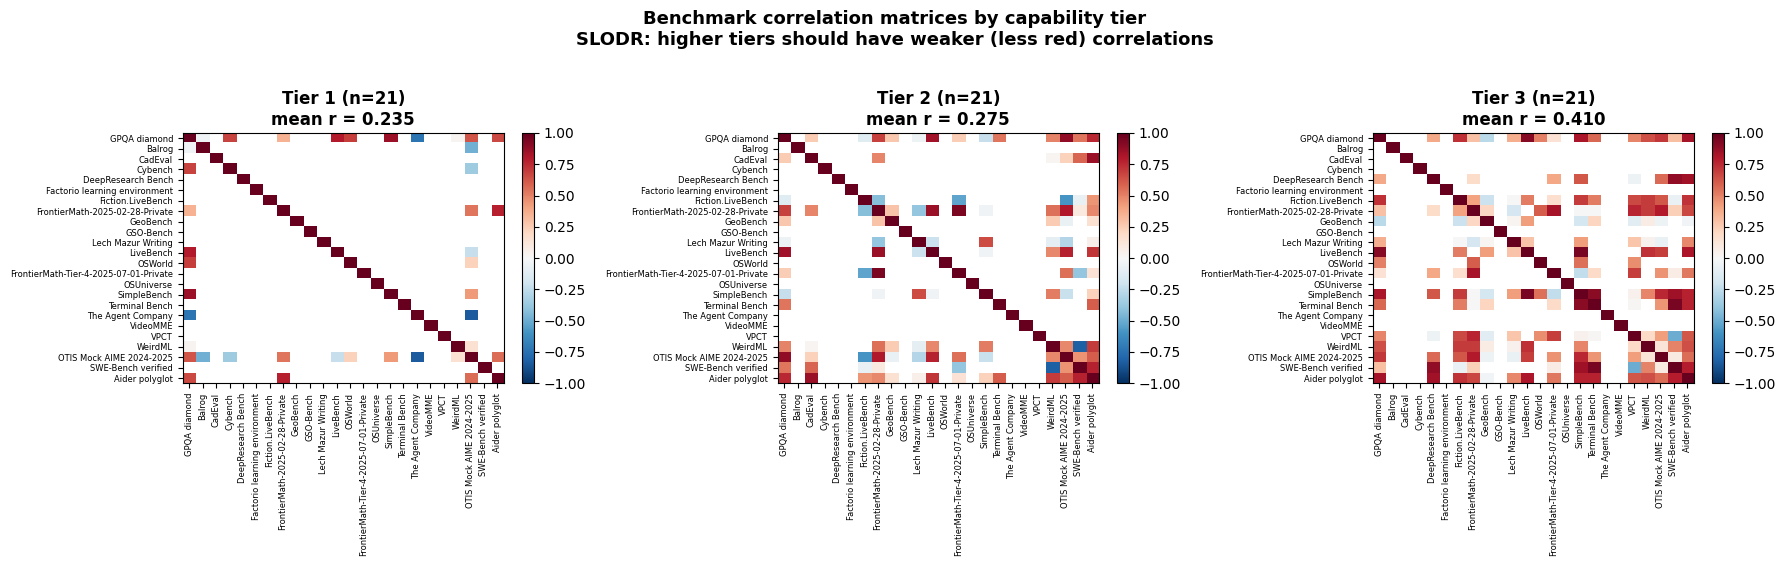

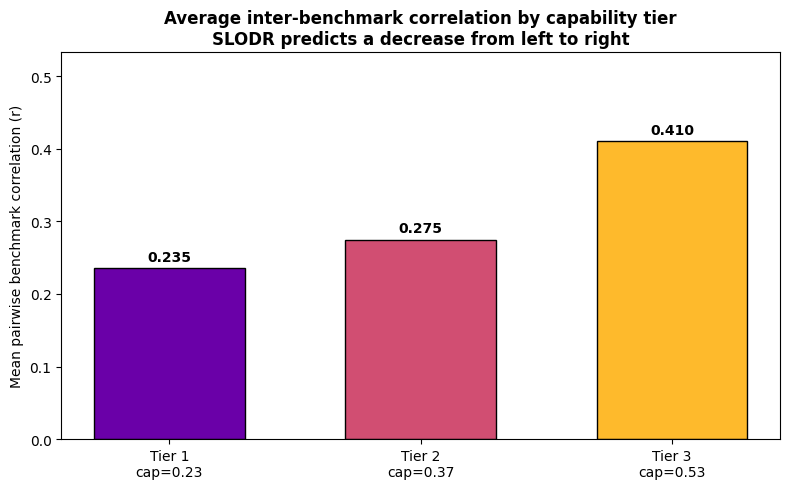

Mean pairwise correlation by tier:
  Tier 1: mean r = +0.235 (20 pairs, median overlap = 1 models)
  Tier 2: mean r = +0.275 (57 pairs, median overlap = 2 models)
  Tier 3: mean r = +0.410 (91 pairs, median overlap = 3 models)

Change from Tier 1 to Tier 3: +0.175
>> ANTI-SLODR: Higher-capability models show HIGHER correlations (more g-loaded).


In [3]:
# === Pairwise Benchmark Correlations by Capability Tier ===
# For each tier, compute every benchmark-pair correlation using ONLY models
# in that tier with observed scores on BOTH benchmarks.
# SLODR prediction: higher-capability tiers have LOWER average correlations.

import numpy as np, matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

MIN_OVERLAP = 5  # minimum models needed in a pair to compute correlation

benchmarks = list(M.columns)
n_bench = len(benchmarks)

tier_corr_mats = {}
tier_overlap_mats = {}
tier_mean_corrs = []

for t in range(N_TIERS):
    models_in_tier = tier_series[tier_series == t].index
    M_tier = M.loc[models_in_tier]

    corr_mat = np.full((n_bench, n_bench), np.nan)
    overlap_mat = np.zeros((n_bench, n_bench), dtype=int)

    for i in range(n_bench):
        corr_mat[i, i] = 1.0
        for j in range(i + 1, n_bench):
            vals_i = M_tier.iloc[:, i].values
            vals_j = M_tier.iloc[:, j].values
            both_obs = ~np.isnan(vals_i) & ~np.isnan(vals_j)
            n_overlap = both_obs.sum()
            overlap_mat[i, j] = overlap_mat[j, i] = n_overlap
            if n_overlap >= MIN_OVERLAP:
                r, _ = pearsonr(vals_i[both_obs], vals_j[both_obs])
                corr_mat[i, j] = corr_mat[j, i] = r

    tier_corr_mats[t] = corr_mat
    tier_overlap_mats[t] = overlap_mat

    # average correlation (upper triangle, excluding NaN)
    upper_idx = np.triu_indices(n_bench, k=1)
    valid = ~np.isnan(corr_mat[upper_idx])
    mean_r = np.nanmean(corr_mat[upper_idx]) if valid.sum() > 0 else np.nan
    tier_mean_corrs.append(mean_r)

# --- Figure 1: correlation matrices per tier ---
fig, axes = plt.subplots(1, N_TIERS, figsize=(6 * N_TIERS, 5.5))
if N_TIERS == 1:
    axes = [axes]
b_labs = [bench_names.get(bid, str(bid)) for bid in benchmarks]
for t in range(N_TIERS):
    im = axes[t].imshow(tier_corr_mats[t], cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")
    axes[t].set_xticks(range(n_bench))
    axes[t].set_xticklabels(b_labs, rotation=90, fontsize=6)
    axes[t].set_yticks(range(n_bench))
    axes[t].set_yticklabels(b_labs, fontsize=6)
    n_in_tier = (tier_series == t).sum()
    axes[t].set_title(f"Tier {t+1} (n={n_in_tier})\nmean r = {tier_mean_corrs[t]:.3f}", fontweight="bold")
    plt.colorbar(im, ax=axes[t], fraction=0.046)
plt.suptitle("Benchmark correlation matrices by capability tier\nSLODR: higher tiers should have weaker (less red) correlations",
             fontsize=13, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# --- Figure 2: mean correlation vs tier ---
fig, ax = plt.subplots(figsize=(8, 5))
tier_capability_means = [capability.values[tier_labels == t].mean() for t in range(N_TIERS)]
ax.bar(range(N_TIERS), tier_mean_corrs, color=colors_t, edgecolor="black", width=0.6)
ax.set_xticks(range(N_TIERS))
ax.set_xticklabels([f"Tier {t+1}\ncap={tier_capability_means[t]:.2f}" for t in range(N_TIERS)])
ax.set_ylabel("Mean pairwise benchmark correlation (r)")
ax.set_title("Average inter-benchmark correlation by capability tier\nSLODR predicts a decrease from left to right",
             fontweight="bold")
ax.set_ylim(0, max(tier_mean_corrs) * 1.3 if max(tier_mean_corrs) > 0 else 1)
for t in range(N_TIERS):
    ax.text(t, tier_mean_corrs[t] + 0.01, f"{tier_mean_corrs[t]:.3f}", ha="center", fontweight="bold")
plt.tight_layout()
plt.show()

print("Mean pairwise correlation by tier:")
for t in range(N_TIERS):
    upper_idx = np.triu_indices(n_bench, k=1)
    valid = ~np.isnan(tier_corr_mats[t][upper_idx])
    n_pairs = valid.sum()
    med_overlap = int(np.median(tier_overlap_mats[t][upper_idx]))
    print(f"  Tier {t+1}: mean r = {tier_mean_corrs[t]:+.3f} ({n_pairs} pairs, median overlap = {med_overlap} models)")

delta = tier_mean_corrs[-1] - tier_mean_corrs[0]
print(f"\nChange from Tier 1 to Tier {N_TIERS}: {delta:+.3f}")
if delta < -0.02:
    print(">> SLODR SUPPORTED: Higher-capability models show lower inter-benchmark correlations.")
elif delta > 0.02:
    print(">> ANTI-SLODR: Higher-capability models show HIGHER correlations (more g-loaded).")
else:
    print(">> INCONCLUSIVE: Minimal change in correlation across tiers.")


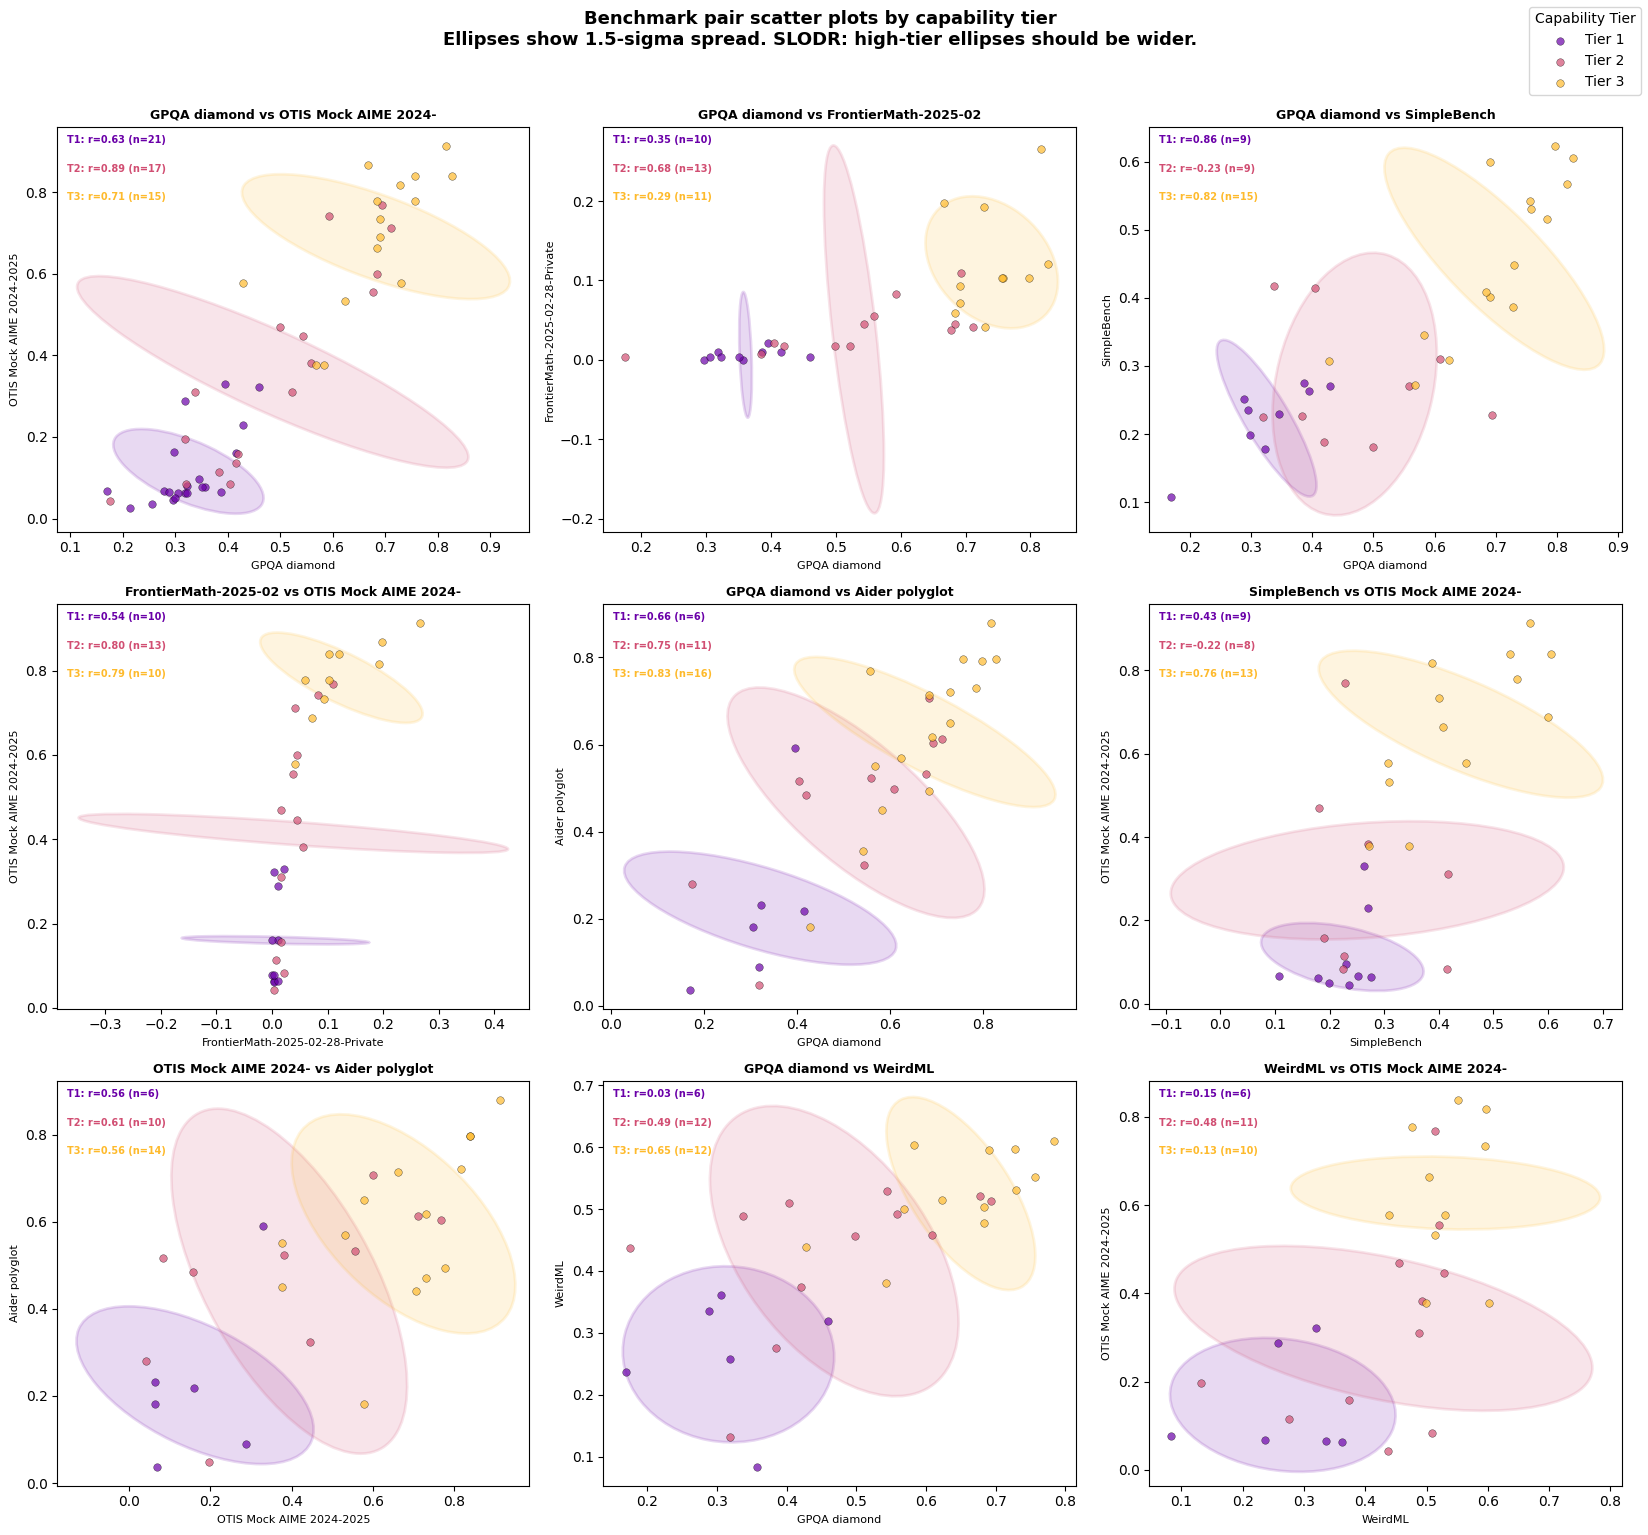

In [4]:
# === Visual SLODR: Benchmark Pair Scatter Plots ===
# Pick the benchmark pairs with the most overlap across tiers.
# Each panel shows one pair; dots coloured by tier.
# SLODR: high-tier dots should be more spread (lower r) than low-tier dots.

import numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import pearsonr
import matplotlib.transforms as transforms

N_PAIRS_TO_SHOW = 9  # will show a grid of this many pairs

# find pairs with best total overlap across all tiers
pair_total_overlap = np.zeros((n_bench, n_bench), dtype=int)
for t in range(N_TIERS):
    pair_total_overlap += tier_overlap_mats[t]

upper_idx = np.triu_indices(n_bench, k=1)
pair_overlaps = pair_total_overlap[upper_idx]
pair_order = np.argsort(pair_overlaps)[::-1]

# also ensure minimum overlap per tier
good_pairs = []
for idx in pair_order:
    i, j = upper_idx[0][idx], upper_idx[1][idx]
    tier_mins = [tier_overlap_mats[t][i, j] for t in range(N_TIERS)]
    if min(tier_mins) >= MIN_OVERLAP:
        good_pairs.append((i, j))
    if len(good_pairs) >= N_PAIRS_TO_SHOW:
        break

if len(good_pairs) < N_PAIRS_TO_SHOW:
    print(f"Only {len(good_pairs)} pairs have >= {MIN_OVERLAP} overlap in every tier.")

n_show = len(good_pairs)
ncols = min(3, n_show)
nrows = int(np.ceil(n_show / ncols))

def draw_confidence_ellipse(x, y, ax, color, n_std=1.5):
    """Draw a covariance-based confidence ellipse."""
    if len(x) < 3:
        return
    cov = np.cov(x, y)
    eigvals, eigvecs = np.linalg.eigh(cov)
    eigvals = np.maximum(eigvals, 0)
    angle = np.degrees(np.arctan2(eigvecs[1, 1], eigvecs[0, 1]))
    w, h = 2 * n_std * np.sqrt(eigvals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)), width=w, height=h, angle=angle,
                  facecolor=color, alpha=0.15, edgecolor=color, lw=2)
    ax.add_patch(ell)

fig, axes = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 5 * nrows))
axes_flat = np.array(axes).flatten() if n_show > 1 else [axes]

for p_idx, (i, j) in enumerate(good_pairs):
    ax = axes_flat[p_idx]
    bn_i = bench_names.get(benchmarks[i], str(benchmarks[i]))
    bn_j = bench_names.get(benchmarks[j], str(benchmarks[j]))

    for t in range(N_TIERS):
        models_in_tier = tier_series[tier_series == t].index
        vals_i = M.loc[models_in_tier, benchmarks[i]].values
        vals_j = M.loc[models_in_tier, benchmarks[j]].values
        both_obs = ~np.isnan(vals_i) & ~np.isnan(vals_j)
        xi, xj = vals_i[both_obs], vals_j[both_obs]

        ax.scatter(xi, xj, c=[colors_t[t]], s=30, alpha=0.7, edgecolors="k",
                   linewidths=0.3, label=f"Tier {t+1}", zorder=3)
        draw_confidence_ellipse(xi, xj, ax, colors_t[t])

        if len(xi) >= 3:
            r, _ = pearsonr(xi, xj)
            # place tier r-values at the top
            ax.text(0.02, 0.98 - t * 0.07, f"T{t+1}: r={r:.2f} (n={len(xi)})",
                    transform=ax.transAxes, fontsize=7, color=colors_t[t],
                    va="top", fontweight="bold")

    ax.set_xlabel(bn_i, fontsize=8)
    ax.set_ylabel(bn_j, fontsize=8)
    ax.set_title(f"{bn_i[:20]} vs {bn_j[:20]}", fontsize=9, fontweight="bold")

# hide unused axes
for idx in range(n_show, len(axes_flat)):
    axes_flat[idx].set_visible(False)

# add shared legend
handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", fontsize=10, title="Capability Tier")
fig.suptitle("Benchmark pair scatter plots by capability tier\n"
             "Ellipses show 1.5-sigma spread. SLODR: high-tier ellipses should be wider.",
             fontsize=13, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


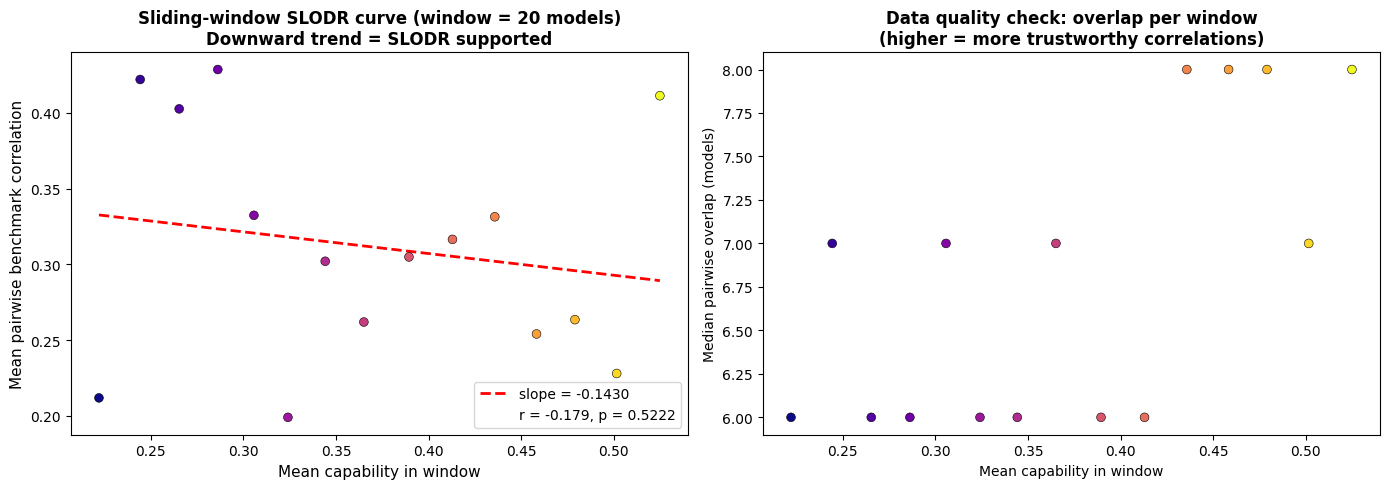

Sliding window (W=20, step=3):
  Slope: -0.1430
  Correlation of mean_r with capability: r = -0.179, p = 0.5222
  >> Trend is not statistically significant.


In [5]:
# === Sliding Window: Continuous SLODR Curve ===
# Sort models by capability, slide a window of W models, compute mean
# pairwise correlation within each window. Plot against capability.
# This avoids arbitrary tier boundaries.

import numpy as np, matplotlib.pyplot as plt
from scipy.stats import pearsonr

WINDOW_SIZE = 20   # number of models per window
STEP = 3           # slide step

model_order = capability.sort_values().index
ordered_cap = capability.loc[model_order].values

window_caps = []
window_mean_rs = []
window_median_overlaps = []

for start in range(0, len(model_order) - WINDOW_SIZE + 1, STEP):
    window_models = model_order[start:start + WINDOW_SIZE]
    M_win = M.loc[window_models]

    # pairwise correlations from observed data only
    rs_in_window = []
    overlaps_in_window = []
    for i in range(n_bench):
        for j in range(i + 1, n_bench):
            vi = M_win.iloc[:, i].values
            vj = M_win.iloc[:, j].values
            both = ~np.isnan(vi) & ~np.isnan(vj)
            n_ov = both.sum()
            if n_ov >= 5:
                r, _ = pearsonr(vi[both], vj[both])
                rs_in_window.append(r)
                overlaps_in_window.append(n_ov)

    if len(rs_in_window) >= 10:
        window_caps.append(ordered_cap[start:start + WINDOW_SIZE].mean())
        window_mean_rs.append(np.mean(rs_in_window))
        window_median_overlaps.append(int(np.median(overlaps_in_window)))

window_caps = np.array(window_caps)
window_mean_rs = np.array(window_mean_rs)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: SLODR curve
axes[0].scatter(window_caps, window_mean_rs, c=window_caps, cmap="plasma",
                s=40, edgecolors="k", linewidths=0.4, zorder=3)
if len(window_caps) >= 3:
    z = np.polyfit(window_caps, window_mean_rs, 1)
    x_fit = np.linspace(window_caps.min(), window_caps.max(), 100)
    axes[0].plot(x_fit, np.polyval(z, x_fit), "r--", lw=2,
                 label=f"slope = {z[0]:+.4f}")
    r_sw, p_sw = pearsonr(window_caps, window_mean_rs)
    axes[0].plot([], [], ' ', label=f"r = {r_sw:+.3f}, p = {p_sw:.4f}")
    axes[0].legend(fontsize=10)
axes[0].set_xlabel("Mean capability in window", fontsize=11)
axes[0].set_ylabel("Mean pairwise benchmark correlation", fontsize=11)
axes[0].set_title(f"Sliding-window SLODR curve (window = {WINDOW_SIZE} models)\n"
                  "Downward trend = SLODR supported", fontweight="bold")

# Right: overlap quality per window
axes[1].scatter(window_caps, window_median_overlaps, c=window_caps, cmap="plasma",
                s=40, edgecolors="k", linewidths=0.4)
axes[1].set_xlabel("Mean capability in window")
axes[1].set_ylabel("Median pairwise overlap (models)")
axes[1].set_title("Data quality check: overlap per window\n(higher = more trustworthy correlations)",
                  fontweight="bold")
plt.tight_layout()
plt.show()

if len(window_caps) >= 3:
    print(f"Sliding window (W={WINDOW_SIZE}, step={STEP}):")
    print(f"  Slope: {z[0]:+.4f}")
    print(f"  Correlation of mean_r with capability: r = {r_sw:+.3f}, p = {p_sw:.4f}")
    if z[0] < 0 and p_sw < 0.05:
        print("  >> SLODR SUPPORTED in sliding-window analysis (no imputation).")
    elif z[0] > 0 and p_sw < 0.05:
        print("  >> ANTI-SLODR: Correlations increase with capability.")
    else:
        print("  >> Trend is not statistically significant.")


/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


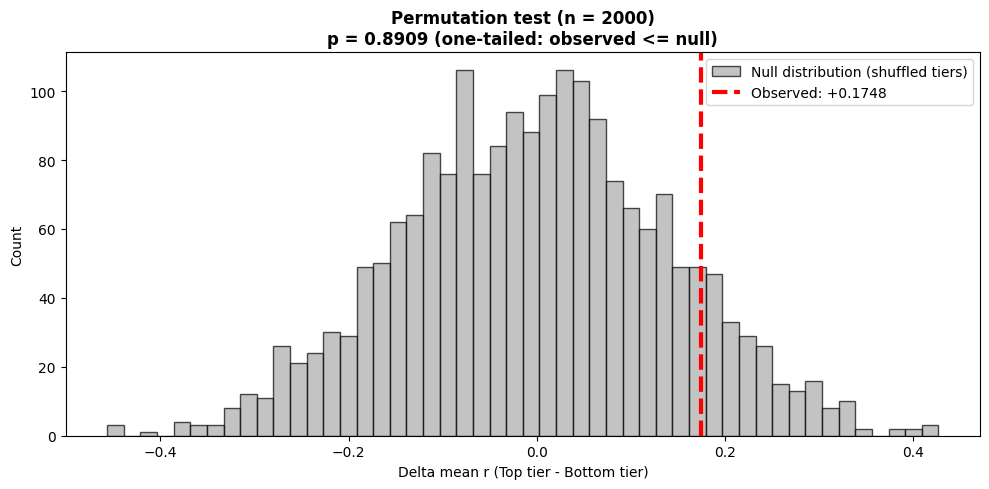

Observed delta (Tier 3 - Tier 1): +0.1748
Null distribution: mean = -0.0023, std = 0.1415
Permutation p-value (one-tailed): 0.8909

No significant evidence for SLODR in this imputation-free analysis.


In [6]:
# === Permutation Test: Is the Tier Difference Significant? ===
# Null hypothesis: capability tier assignment is unrelated to inter-benchmark
# correlation structure.
# Procedure: shuffle tier labels, recompute mean-r per tier, record the
# difference (Tier_last - Tier_1). Compare observed difference to null distribution.

import numpy as np, matplotlib.pyplot as plt
from scipy.stats import pearsonr

N_PERMUTATIONS = 2000

# observed statistic: mean_r(top tier) - mean_r(bottom tier)
observed_delta = tier_mean_corrs[-1] - tier_mean_corrs[0]

# precompute per-pair data to speed up permutations
pair_data = {}
for i in range(n_bench):
    for j in range(i + 1, n_bench):
        vals_i = M.iloc[:, i].values
        vals_j = M.iloc[:, j].values
        both = ~np.isnan(vals_i) & ~np.isnan(vals_j)
        if both.sum() >= MIN_OVERLAP:
            pair_data[(i, j)] = (vals_i[both], vals_j[both],
                                 np.array(M.index)[both])

def compute_tier_mean_r(tier_assignment, tier_val, model_index):
    """Compute mean pairwise correlation for models in a given tier."""
    tier_models = set(model_index[tier_assignment == tier_val])
    rs = []
    for (i, j), (vi, vj, model_ids) in pair_data.items():
        in_tier = np.array([m in tier_models for m in model_ids])
        if in_tier.sum() >= MIN_OVERLAP:
            r, _ = pearsonr(vi[in_tier], vj[in_tier])
            rs.append(r)
    return np.mean(rs) if rs else np.nan

model_index = np.array(M.index)
tier_assignment = tier_labels.copy()

null_deltas = []
rng = np.random.default_rng(42)

for perm in range(N_PERMUTATIONS):
    shuffled = rng.permutation(tier_assignment)
    r_low = compute_tier_mean_r(shuffled, 0, model_index)
    r_high = compute_tier_mean_r(shuffled, N_TIERS - 1, model_index)
    if not np.isnan(r_low) and not np.isnan(r_high):
        null_deltas.append(r_high - r_low)

null_deltas = np.array(null_deltas)

# p-value (one-tailed: how often is null delta <= observed delta, for negative SLODR)
p_perm = np.mean(null_deltas <= observed_delta) if len(null_deltas) > 0 else np.nan

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(null_deltas, bins=50, color="#AAAAAA", edgecolor="black", alpha=0.7,
        label="Null distribution (shuffled tiers)")
ax.axvline(observed_delta, color="red", lw=3, ls="--",
           label=f"Observed: {observed_delta:+.4f}")
ax.set_xlabel("Delta mean r (Top tier - Bottom tier)")
ax.set_ylabel("Count")
ax.set_title(f"Permutation test (n = {N_PERMUTATIONS})\n"
             f"p = {p_perm:.4f} (one-tailed: observed <= null)",
             fontweight="bold")
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

print(f"Observed delta (Tier {N_TIERS} - Tier 1): {observed_delta:+.4f}")
print(f"Null distribution: mean = {null_deltas.mean():+.4f}, std = {null_deltas.std():.4f}")
print(f"Permutation p-value (one-tailed): {p_perm:.4f}")
print()
if p_perm < 0.01:
    print("** Strong evidence for SLODR (p < 0.01). The tier difference is very unlikely under the null.")
elif p_perm < 0.05:
    print("* Evidence for SLODR (p < 0.05). The tier difference is unlikely under the null.")
elif p_perm < 0.10:
    print("Marginal evidence for SLODR (p < 0.10). Suggestive but not conclusive.")
else:
    print("No significant evidence for SLODR in this imputation-free analysis.")
